# __LeNet - MXNet (From Scratch)__

In [1]:
import mxnet as mx
from mxnet import nd, autograd, gluon
from mxnet.gluon import nn
import matplotlib.pyplot as plt

ctx = mx.gpu()

## __Getting the dataset__

AlexNet was made to be trained on imagenet dataset, which is a massive dataset of coloured images with shape of (3, 224, 224), so we need to resize our mnist image from (1, 28, 28) to (1, 224, 224), otherwise in forward propagation it's gonna show error because AlexNet uses larger sized kernels and pooling sizes.

In [9]:
def transform(data, label):
    data = data.astype('float32')/255.0
    data = mx.image.imresize(data, 224, 224) # herer we are resising the mnist image
    return data.transpose((2, 0, 1)), label.astype('float32')

train_mnist = gluon.data.vision.MNIST(train = True, transform = transform)
test_mnist = gluon.data.vision.MNIST(train = False, transform = transform)

In [10]:
image, label = train_mnist[1]
print(image.shape)
print(label)

(1, 224, 224)
0.0


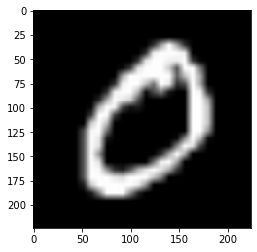

In [11]:
plt.imshow(image[0].asnumpy(), 'gray')
plt.show()

## __Defining data loaders__

In [12]:
batch_size = 64
train_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = True)
test_data = gluon.data.DataLoader(train_mnist, batch_size = batch_size, shuffle = False)

## __Defining LeNet Model Architecture__

In [13]:
model = nn.HybridSequential()

model.add(nn.Conv2D(channels = 96, kernel_size = (11, 11), strides = (4, 4)))
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(nn.Conv2D(channels = 256, kernel_size = (5, 5), padding = (2, 2)))
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(nn.Conv2D(channels = 384, kernel_size = (3, 3), padding = (1, 1)))
model.add(nn.Activation('relu'))
model.add(nn.Conv2D(channels = 384, kernel_size = (3, 3), padding = (1, 1)))
model.add(nn.Activation('relu'))
model.add(nn.Conv2D(channels = 256, kernel_size = (3, 3), padding = (1, 1)))
model.add(nn.Activation('relu'))
model.add(nn.MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

model.add(nn.Flatten())

model.add(nn.Dense(4096, activation = 'relu'))
model.add(nn.Dropout(0.5))
model.add(nn.Dense(4096, activation = 'relu'))
model.add(nn.Dropout(0.5))
model.add(nn.Dense(10))

model.initialize(mx.init.Xavier(), ctx)
model

HybridSequential(
  (0): Conv2D(None -> 96, kernel_size=(11, 11), stride=(4, 4))
  (1): Activation(relu)
  (2): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (3): Conv2D(None -> 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): Activation(relu)
  (5): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (6): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): Activation(relu)
  (8): Conv2D(None -> 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): Activation(relu)
  (10): Conv2D(None -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): Activation(relu)
  (12): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (13): Flatten
  (14): Dense(None -> 4096, Activation(relu))
  (15): Dropout(p = 0.5, axes=())
  (16): Dense

## __Summarizing the model__

In [14]:
model.summary(image.expand_dims(0).as_in_context(ctx))

--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (1, 1, 224, 224)               0
            Conv2D-1                             (1, 96, 54, 54)           11712
        Activation-2                             (1, 96, 54, 54)               0
         MaxPool2D-3                             (1, 96, 26, 26)               0
            Conv2D-4                            (1, 256, 26, 26)          614656
        Activation-5                            (1, 256, 26, 26)               0
         MaxPool2D-6                            (1, 256, 12, 12)               0
            Conv2D-7                            (1, 384, 12, 12)          885120
        Activation-8                            (1, 384, 12, 12)               0
            Conv2D-9                            (1, 384, 12, 12)         1327488
       Activation-10        

## __Visualizing model architecture__

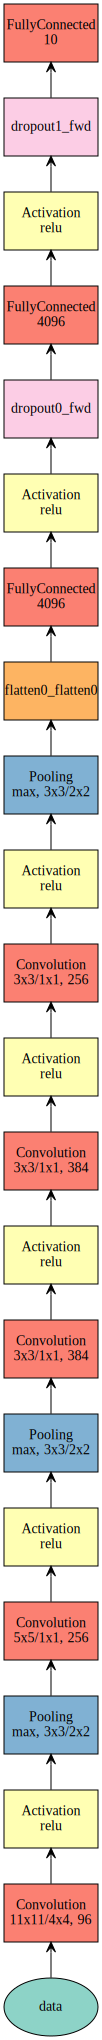

In [15]:
mx.viz.plot_network(model(mx.sym.var(name = 'data', shape = (1, 1, 224, 224))))

By hybridizing the model becomes almost 1.5x fast, as it converts dynamically defined model in to static graph. Its a really cool feature that MXNet provides

In [16]:
model.hybridize()

## __Defining our objective loss and optimizer__

In [17]:
objective = gluon.loss.SoftmaxCrossEntropyLoss()
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': 0.001})

## __Training the model__

In [18]:
epochs = 10
batches = len(train_data)
acc = mx.metric.Accuracy()

for epoch in range(epochs):
    acc.reset()
    cum_loss = 0.0
    for features, labels in train_data:
        features = features.as_in_context(ctx)
        labels = labels.as_in_context(ctx)

        with autograd.record():
            outputs = model(features)
            loss = objective(outputs, labels)
        loss.backward()
        trainer.step(batch_size)

        cum_loss += loss.mean()
        acc.update(labels, outputs)
    
    print(f'Epoch: {epoch + 1} | Loss: {cum_loss.asscalar()/batches:.5f} | Training Accuracy: {acc.get()[1]:.5f}')

Epoch: 1 | Loss: 0.21265 | Training Accuracy: 0.9331833333333334
Epoch: 2 | Loss: 0.07333 | Training Accuracy: 0.97945


KeyboardInterrupt: 

## __Testing the model__

In [19]:
acc.reset()
for features, labels in test_data:
    features = features.as_in_context(ctx)
    labels = labels.as_in_context(ctx)
    outputs = model(features)
    acc.update(labels, outputs)
acc.get()

('accuracy', 0.9831833333333333)